# Toxic comments - Iteration # 3

### Date: 27th Nov 2020
Sherry

The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [3]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [ ]:
help(BinaryClassificationPerformance)

## Data cleaning and pruning - not incorporated yet

In [3]:
# exploring the dataset - not used in model-building
train_dataset = pd.read_csv('../../data/toxiccomments_train.csv')


In [4]:
train_dataset[train_dataset.comment_text == 'Sorry Monkey the page got locked while we figure out who you are and report you to your employer.  YOU got pwned!   User:DONNY PWNED YOU']

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
90865,f3175595f7f157e3,Sorry Monkey the page got locked while we figu...,0,0,0,0,0,0


# Function for feature building and extraction on natural language data

#### Changes made to feature building and extraction:
  1. **added bigrams**
  
        `hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, ngram_range=(1,2))`
        
        
  2. **added smooth_idf parameter as False**
  
        `TfidfTransformer(smooth_idf=False)`
        
        
  3. **Added two features: question counts and exclamation counts**
            `toxic_data['exclaim_count'] = toxic_data['comment_text'].str.count("\!")`
            `toxic_data['quest_count'] = toxic_data['comment_text'].str.count("\?")`
       

In [4]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
#         hv = HashingVectorizer(n_features=2 ** 13, alternate_sign=False, strip_accents = 'ascii', ngram_range=(3,5), stop_words='english', analyzer = 'word')
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, ngram_range=(1,2))
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer(smooth_idf=False)
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['exclaim_count'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['quest_count'] = toxic_data['comment_text'].str.count("\?")

    
#     toxic_data['allcaps_count'] = toxic_data['comment_text'].str.findall(r'[A-Z]').str.len()

#     X_quant_features = toxic_data[["word_count", "exclaim_count", "allcaps_count"]]
    X_quant_features = toxic_data[["word_count", "exclaim_count", "quest_count"]]
#     X_quant_features = toxic_data[["word_count", "exclaim_count"]]


    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [5]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../../data/toxiccomments_train.csv', my_random_seed=1999)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [21]:
# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X_train, y_train)

# ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
# ols_performance_train.compute_measures()
# print(ols_performance_train.performance_measures)

### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12953, 'TN': 114671, 'FP': 14, 'FN': 18, 'Accuracy': 0.9997493263144701, 'Precision': 0.998920336238143, 'Recall': 0.9986122889522782, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12952, 'TN': 114667, 'FP': 18, 'FN': 19, 'Accuracy': 0.9997101585511061, 'Precision': 0.9986121819583654, 'Recall': 0.9985351938940714, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12659, 'TN': 109374, 'FP': 5311, 'FN': 312, 'Accuracy': 0.9559519333207996, 'Precision': 0.7044518642181413, 'Recall': 0.9759463418394881, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12957, 'TN': 114657, 'FP': 28, 'FN': 14, 'Accuracy': 0.999670990787742, 'Precision': 0.997843665768194, 'Recall': 0.9989206691851052, 'desc': 'prc_train'}


### MODEL: SVM-C

In [10]:
from sklearn.svm import LinearSVC
svmc_0002 = LinearSVC(loss='hinge', C=0.0002)
svmc_0002.fit(X_train, y_train)

svmc_0002_performance_train = BinaryClassificationPerformance(svmc_0002.predict(X_train), y_train, 'svmc_0002_train')
svmc_0002_performance_train.compute_measures()
print(svmc_0002_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


{'Pos': 12971, 'Neg': 114685, 'TP': 12940, 'TN': 114672, 'FP': 13, 'FN': 31, 'Accuracy': 0.9996553236823964, 'Precision': 0.9989963714969505, 'Recall': 0.9976100531955902, 'desc': 'svmc_0002_train'}


### MODEL: Ridge Regression Classifier

#### Changes made to ridge regression classifier:

  1. **change alphas to 800, 50, 30, 20, 25, 35, 50000**
  
          
  2. **added normalization parameter and changed the solver to the SAG methodology**
  
        `normalize=True, solver='sag'`
        
        This doesn't work on higher alphas though - error of scalars
        
       

#### MODEL: Ridge Regression Classifier (alpha = 800)

In [11]:
rdg_800 = linear_model.RidgeClassifier(alpha = 800, normalize=True, solver='sag')
rdg_800.fit(X_train, y_train)

rdg_800_performance_train = BinaryClassificationPerformance(rdg_800.predict(X_train), y_train, 'rdg_800_train')
rdg_800_performance_train.compute_measures()
print(rdg_800_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 12971, 'Neg': 114685, 'TP': 10160, 'TN': 113448, 'FP': 1237, 'FN': 2811, 'Accuracy': 0.9682897787804725, 'Precision': 0.891462665613758, 'Recall': 0.7832857913807725, 'desc': 'rdg_800_train'}


#### MODEL: Ridge Regression Classifier (alpha = 50)

In [12]:
rdg_50 = linear_model.RidgeClassifier(alpha = 50, normalize=True, solver='sag')
rdg_50.fit(X_train, y_train)

rdg_50_performance_train = BinaryClassificationPerformance(rdg_50.predict(X_train), y_train, 'rdg_50_train')
rdg_50_performance_train.compute_measures()
print(rdg_50_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 12971, 'Neg': 114685, 'TP': 12448, 'TN': 107271, 'FP': 7414, 'FN': 523, 'Accuracy': 0.9378250924359215, 'Precision': 0.6267243983486054, 'Recall': 0.9596792845578599, 'desc': 'rdg_50_train'}


#### MODEL: Ridge Regression Classifier (alpha = 30)

In [13]:
from sklearn import linear_model
rdg_30 = linear_model.RidgeClassifier(alpha = 30, normalize=True, solver='sag')
rdg_30.fit(X_train, y_train)

rdg_30_performance_train = BinaryClassificationPerformance(rdg_30.predict(X_train), y_train, 'rdg_30_train')
rdg_30_performance_train.compute_measures()
print(rdg_30_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 12971, 'Neg': 114685, 'TP': 12665, 'TN': 105789, 'FP': 8896, 'FN': 306, 'Accuracy': 0.9279156483048192, 'Precision': 0.587403181670609, 'Recall': 0.9764089121887287, 'desc': 'rdg_30_train'}


#### MODEL: Ridge Regression Classifier (alpha = 20)

In [14]:
from sklearn import linear_model
rdg_20 = linear_model.RidgeClassifier(alpha = 20, normalize=True, solver='sag')
rdg_20.fit(X_train, y_train)

rdg_20_performance_train = BinaryClassificationPerformance(rdg_20.predict(X_train), y_train, 'rdg_20_train')
rdg_20_performance_train.compute_measures()
print(rdg_20_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 12971, 'Neg': 114685, 'TP': 12794, 'TN': 104493, 'FP': 10192, 'FN': 177, 'Accuracy': 0.9187738923356521, 'Precision': 0.5565996693639607, 'Recall': 0.9863541746974019, 'desc': 'rdg_20_train'}


#### MODEL: Ridge Regression Classifier (alpha = 25)

In [15]:
from sklearn import linear_model
rdg_25 = linear_model.RidgeClassifier(alpha = 25, normalize=True, solver='sag')
rdg_25.fit(X_train, y_train)

rdg_25_performance_train = BinaryClassificationPerformance(rdg_25.predict(X_train), y_train, 'rdg_25_train')
rdg_25_performance_train.compute_measures()
print(rdg_25_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 12971, 'Neg': 114685, 'TP': 12723, 'TN': 105227, 'FP': 9458, 'FN': 248, 'Accuracy': 0.9239675377577239, 'Precision': 0.5735990261935892, 'Recall': 0.9808804255647213, 'desc': 'rdg_25_train'}


#### MODEL: Ridge Regression Classifier (alpha = 35)

In [16]:
from sklearn import linear_model
rdg_35 = linear_model.RidgeClassifier(alpha = 35, normalize=True, solver='sag')
rdg_35.fit(X_train, y_train)

rdg_35_performance_train = BinaryClassificationPerformance(rdg_35.predict(X_train), y_train, 'rdg_35_train')
rdg_35_performance_train.compute_measures()
print(rdg_35_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 12971, 'Neg': 114685, 'TP': 12603, 'TN': 106240, 'FP': 8445, 'FN': 368, 'Accuracy': 0.9309629002945415, 'Precision': 0.5987742303306728, 'Recall': 0.971629018579909, 'desc': 'rdg_35_train'}


#### MODEL: Ridge Regression Classifier (alpha = 50000)

In [17]:
from sklearn import linear_model
rdg_50000 = linear_model.RidgeClassifier(alpha = 50000)
rdg_50000.fit(X_train, y_train)

rdg_50000_performance_train = BinaryClassificationPerformance(rdg_50000.predict(X_train), y_train, 'rdg_50000_train')
rdg_50000_performance_train.compute_measures()
print(rdg_50000_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12753, 'TN': 114670, 'FP': 15, 'FN': 218, 'Accuracy': 0.9981747822272357, 'Precision': 0.9988251879699248, 'Recall': 0.9831932773109243, 'desc': 'rdg_50000_train'}


### MODEL: Random Forest Classifier

In [15]:
# from sklearn.ensemble import RandomForestClassifier
# rdf = RandomForestClassifier(random_state=0)
# rdf.fit(X_train, y_train)

# rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
# rdf_performance_train.compute_measures()
# print(rdf_performance_train.performance_measures)

### ROC plot to compare performance of various models and fits

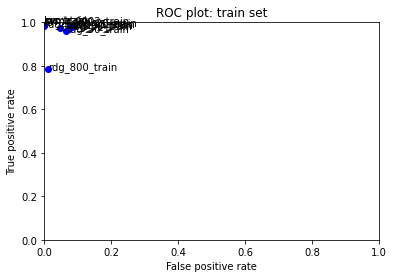

In [18]:
# fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
# fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train]
# fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_50_performance_train, svmc_0002_performance_train, rdg_800_performance_train, rdg_50000_performance_train]
fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_50_performance_train,rdg_30_performance_train,rdg_20_performance_train, rdg_25_performance_train, rdg_35_performance_train, svmc_0002_performance_train, rdg_800_performance_train, rdg_50000_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [88]:
rdg_predictions = rdg.predict(X_train)

In [89]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
26
How odd - at no stage have I ever said we are the shopping centre management – maybe we are and maybe we’re not. Maybe we’re marketing agents/team/consultants and maybe we’re not – who knows - although one thing is certain -  far greater powers than you have kept our article and link, which suggests to me you are as insignificant as those who dare to challenge us in this area. Money talks and bullshit walks so bye bye and go away and edit some insignificant lesbian topic.  Our team will be watching any attempted edits you try, so unless you want to be thrown out of Wikipedia I would not even think about editing our article – many others before you have tried and all have failed miserably:-)
* * * * * * * * * 
69
Sorry Monkey the page got locked while we figure out who you are and report you to your employer.  YOU got pwned!   User:DONNY PWNED YOU
* * * * * * * * * 
485
All fake. Sorry. —  (T | C)
* * * * * * * * * 
491
Wiki is a two way street, deleting 

Hey man, yeah but my mother is gonna be back in a month so I won't have it any ealier. I will put it online or whatever as soon as I get it. In the meantime again if there is anything else that would be cool let me know
* * * * * * * * * 
10926
.
oh, leave me alone ;)
* * * * * * * * * 
11264
I never did delete the bike bit so do what you like.
* * * * * * * * * 
11614
"

Please keep your ""warnings"" to yourself
Edits that you do not agree with do not qualify as ""vandalism"" simply because you disagree.   "
* * * * * * * * * 
12302
Wikipedia 

Why do you bother wasting your time with this site? 194.189.32.65
* * * * * * * * * 
12310
hello mr noq you are giving wrong information
shame on you .every one knows Varanasi kingdom historically belongs to bhumihar brahmin kings.then how rajput and martaha kings come and rule in 18th century and make most of the buildings,shame on you.why you reverting my edits thankyou for your support
* * * * * * * * * 
12383
That's of course apart from the

27373
Piper Cherokee 

Why you have called it POV?
* * * * * * * * * 
27692
Stalker

Whats your problem? Why the heck are you always stalking my posts and edits? If it makes you feel big pushing me and Aryan around like that then you better stop before I report it. And I was not in a edit war, I put it up for deletion after people in the talk page were discussing its deletion, Aryan kept getting rid of it.
* * * * * * * * * 
28573
STOP SPAMMING BLOGS IN EXTERNAL LINKS OR YOU WILL GET BANNED FROM WIKIPEDIA 

STOP SPAMMING BLOGS IN EXTERNAL LINKS OR YOU WILL GET BANNED FROM WIKIPEDIA
* * * * * * * * * 
28870
Hi I am your biggest fan!
* * * * * * * * * 
29663
That said I love you man
* * * * * * * * * 
30339
Beat perfect 
Has any fan ever beat the game perfectly without getting busted, wasted, failing a mission, or saving the game?
* * * * * * * * * 
31511
Devil's City 
I've been to Ashabat and it's really awful. It's a boring piss-poor hole during the day and a dangerous hell hole at nig

Don't be dense. -user
* * * * * * * * * 
41286
Whatever. Just chill. What are you, a robot? This is an encyclopaedia, and whilst high standards must be kept, I fear you're abusing your power.
* * * * * * * * * 
41617
"Answer: who cares?  what we do know is that he is an unqualified twit.  And he looks like Mr. Burns from ""The Simpsons""

"
* * * * * * * * * 
42584
Likes to watch old men play football on a summer day when u were gone
* * * * * * * * * 
42907
thats freaky how you knew i was Latino no i dont need to go to all white London lol just kidding i just said this to get peoples pissed off and say somthing sorry i know London but it has no gangs >_< just mobs and Cartel ^.^
* * * * * * * * * 
43029
This latter site is obviously a front for Pakistani terrorists.
* * * * * * * * * 
43083
"

Why? Just because it's policy? What do you think this is? Wikipedia?...oh...wait... ···? · Talk to Nihonjoe "
* * * * * * * * * 
43349
how do you create pages?∞
* * * * * * * * * 
44099
How is i

50490
that every night? I wanna feel your body sooo bad!
* * * * * * * * * 
50867
Do you like to wear adult diapers for fun? I do.
* * * * * * * * * 
52298
stop your tomfoolery, chap 

I guess that you are the son of the party boss. Well, you have amply displayed your intelligence level. Now, cease and desist. 59.91.253.110
* * * * * * * * * 
52339
Your mouth says stop but your eyes say keep goooing!
* * * * * * * * * 
52343
Can I whsssssssssssssssssssssssssssper it in your ear ?  209.68.5.177
* * * * * * * * * 
53269
This article is a puff piece for Felix Rohatyn, a man many regard as a Nazi worm.
* * * * * * * * * 
53690
Excuse me, I don't like being ignored...could you please respond?
* * * * * * * * * 
53764
Further more your should unblock me and resign your adminship, you are not fit to be incharge of anything.
* * * * * * * * * 
53776
Ruthless For Life
Can someone upload the Ruthless for Life album cover for Ren's discography pleaze?
* * * * * * * * * 
54094
Stop Wiki-stalking m

64511
, 28 March 2007 (UTC)

Man you need 2 get a life are you in the wikipedia 23/7 or what? It is a chetnik site cuz it´s showin chetnik propaganda and false history, I didn´t say it was chetnik cuz a Serb wrote it.

Chetnik ideology = The ideology of Great Serbia

This site produces that sort of false chetnik history. 21:49
* * * * * * * * * 
64515
"

So you blocked me because I reverted WTF's edits? If that's the case, then why isn't   "
* * * * * * * * * 
64563
oh my god... not the board.. will they punish me..lol.. you spend too much time on wikipedia I think...lol
* * * * * * * * * 
64656
Oh, bugger off, Kate!
* * * * * * * * * 
64702
friendly notice 

hey BilCat, what's your problem?
* * * * * * * * * 
65228
Vandalism Claim 
What are personal attacks? I said that it was an anti-fan anyway.
Isn't it you that began vandalism? Wiki is the place where you should write a fact precisely, not your agreement or objection.
* * * * * * * * * 
65720
Nobody said that. But you have a COI an

Hi TRPoD, I hear you are still being one of the 5 horsemen of Wikipedia, trying to astroturf the narrative on the GamerGate Controversy page.  I congratulate you on your sterling efforts to maintain Wikipedia's most uniquely biased article.  I hope you let us all know how much you are being paid at the end of this.  I hope you aren't doing it as a freebie.  Kiss Kiss. 62.254.196.200
* * * * * * * * * 
85926
You may be interested to know that the editor who I called a troll has been indefinitely banned for being a troll, having even gone so far as to explicitly state that they are a troll.  Your hurry to condemn me for calling them a troll, without any effort to understand the situation you were wading into, makes you a sanctimonious prick.  190.162.52.196
* * * * * * * * * 
86828
doesnt matter all you do is isnsult me when i didnt do a songle thing wrong okay so its all your fault
* * * * * * * * * 
87535
Fleming Island High is the worst school ever so dont come here.
* * * * * * * * *

"I'm putting this behind me and concentrating on other things. Not going to touch the sore until it heals. Block me if you will. Sure. Who cares? Mar  

"
* * * * * * * * * 
105830
This is nonsense. I came to this talk page to simply give my view and evidence why and montanas defender was nothing but rude and aggresive. Aswell as deleting my posts he also called me a jerk wad and a nazi lover (which you apparently missed) and was generally hostile for no reason. Despite this hes been given a 'warning' despite being banned before whilst i've just being outright banned!
* * * * * * * * * 
106011
No no, I dont think so at all. This is a very good article about SL forces. No need to change it. And bloody sign your posts next time you bloody guys. Child_Soldier 23:14 24 Nov 2006 (UTC)
* * * * * * * * * 
106076
Let me guess, You're going to try and convince one of your admin buddies that i broke some obscure rule?, Compared to what you have done (Repeatedly insulting Gamergate supporters, Ta

120322
Block 

Why do you say someone is idiotic and ban them for personal attatcks when calling someone idiotic is a personal attack? Shouldnt you be banned? I suppose not because this is not a democracy on this site its run like Hitler ran Germany.
* * * * * * * * * 
120526
Here is something for you to delete/ban/triple block/do what ever you want to:

There is something seriously wrong with you when you think you can just vandalise/delete a different opinion.

You are part of the human race. Wikipedia is a written copy of the human existance. So, you have a right to be here. 

Congratulations with showing your lack of character.

Obviously, you expect a great deal of respect - when you deserve none.

You are like inflation or lukemia - a cancer to Wikipedia. You and your type destroy the real value of Wikipedia. 

But, you exist, and you are part of our beautiful human race. So, have your fun.

You make me sick. 

You and your type destroy the real value of Wikipedia.
* * * * * * * 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [30]:
# ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
# ols_performance_test.compute_measures()
# print(ols_performance_test.performance_measures)

### MODEL: SVM, linear

In [19]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 1897, 'TN': 27409, 'FP': 1252, 'FN': 1357, 'Accuracy': 0.9182516058279806, 'Precision': 0.6024134645919339, 'Recall': 0.5829748002458512, 'desc': 'svm_test'}


### MODEL: logistic regression

In [20]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 1897, 'TN': 27478, 'FP': 1183, 'FN': 1357, 'Accuracy': 0.920413598621338, 'Precision': 0.615909090909091, 'Recall': 0.5829748002458512, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [21]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 1445, 'TN': 26950, 'FP': 1711, 'FN': 1809, 'Accuracy': 0.8897070343098856, 'Precision': 0.4578580481622307, 'Recall': 0.44406883835279654, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [22]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)


{'Pos': 3254, 'Neg': 28661, 'TP': 1922, 'TN': 27423, 'FP': 1238, 'FN': 1332, 'Accuracy': 0.9194736017546609, 'Precision': 0.6082278481012658, 'Recall': 0.5906576521204672, 'desc': 'prc_test'}


### MODEL: SVM-C

In [23]:
svmc_0002_performance_test = BinaryClassificationPerformance(svmc_0002.predict(X_test), y_test, 'svmc_0002_test')
svmc_0002_performance_test.compute_measures()
print(svmc_0002_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 1990, 'TN': 27463, 'FP': 1198, 'FN': 1264, 'Accuracy': 0.9228575904746984, 'Precision': 0.624215809284818, 'Recall': 0.6115550092194223, 'desc': 'svmc_0002_test'}


### MODEL: Ridge Regression Classifier

#### MODEL: Ridge Regression Classifier (alpha = 800)

In [24]:
rdg_800_performance_test = BinaryClassificationPerformance(rdg_800.predict(X_test), y_test, 'rdg_800_test')
rdg_800_performance_test.compute_measures()
print(rdg_800_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 1882, 'TN': 28272, 'FP': 389, 'FN': 1372, 'Accuracy': 0.9448221839260535, 'Precision': 0.8287098194627918, 'Recall': 0.5783650891210818, 'desc': 'rdg_800_test'}


#### MODEL: Ridge Regression Classifier (alpha = 50)

In [25]:
rdg_50_performance_test = BinaryClassificationPerformance(rdg_50.predict(X_test), y_test, 'rdg_50_test')
rdg_50_performance_test.compute_measures()
print(rdg_50_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2712, 'TN': 26267, 'FP': 2394, 'FN': 542, 'Accuracy': 0.9080056399812001, 'Precision': 0.5311398354876615, 'Recall': 0.8334357713583282, 'desc': 'rdg_50_test'}


#### MODEL: Ridge Regression Classifier (alpha = 30)

In [26]:
rdg_30_performance_test = BinaryClassificationPerformance(rdg_30.predict(X_test), y_test, 'rdg_30_test')
rdg_30_performance_test.compute_measures()
print(rdg_30_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2814, 'TN': 25721, 'FP': 2940, 'FN': 440, 'Accuracy': 0.8940936863543788, 'Precision': 0.48905109489051096, 'Recall': 0.8647818070067609, 'desc': 'rdg_30_test'}


#### MODEL: Ridge Regression Classifier (alpha = 20)

In [27]:
rdg_20_performance_test = BinaryClassificationPerformance(rdg_20.predict(X_test), y_test, 'rdg_20_test')
rdg_20_performance_test.compute_measures()
print(rdg_20_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2897, 'TN': 25195, 'FP': 3466, 'FN': 357, 'Accuracy': 0.8802130659564468, 'Precision': 0.45528838598145527, 'Recall': 0.8902888752304856, 'desc': 'rdg_20_test'}


#### MODEL: Ridge Regression Classifier (alpha = 25)

In [28]:
rdg_25_performance_test = BinaryClassificationPerformance(rdg_25.predict(X_test), y_test, 'rdg_25_test')
rdg_25_performance_test.compute_measures()
print(rdg_25_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2850, 'TN': 25489, 'FP': 3172, 'FN': 404, 'Accuracy': 0.8879523734920883, 'Precision': 0.47326469611424776, 'Recall': 0.8758451137062078, 'desc': 'rdg_25_test'}


#### MODEL: Ridge Regression Classifier (alpha = 35)

In [29]:
rdg_35_performance_test = BinaryClassificationPerformance(rdg_35.predict(X_test), y_test, 'rdg_35_test')
rdg_35_performance_test.compute_measures()
print(rdg_35_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2779, 'TN': 25895, 'FP': 2766, 'FN': 475, 'Accuracy': 0.8984490051699827, 'Precision': 0.5011722272317403, 'Recall': 0.8540258143822987, 'desc': 'rdg_35_test'}


#### MODEL: Ridge Regression Classifier (alpha = 50000)

In [30]:
rdg_50000_performance_test = BinaryClassificationPerformance(rdg_50000.predict(X_test), y_test, 'rdg_50000_test')
rdg_50000_performance_test.compute_measures()
print(rdg_50000_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 1583, 'TN': 28440, 'FP': 221, 'FN': 1671, 'Accuracy': 0.9407175309415635, 'Precision': 0.8774944567627494, 'Recall': 0.4864781807006761, 'desc': 'rdg_50000_test'}


### MODEL: Random Forest Classifier

In [44]:
# rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
# rdf_performance_test.compute_measures()
# print(rdf_performance_test.performance_measures)

### ROC plot to compare performance of various models and fits

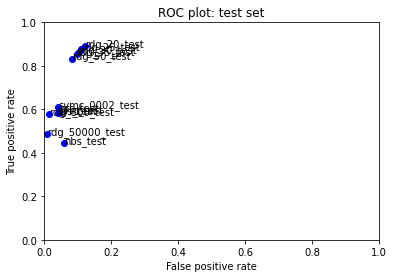

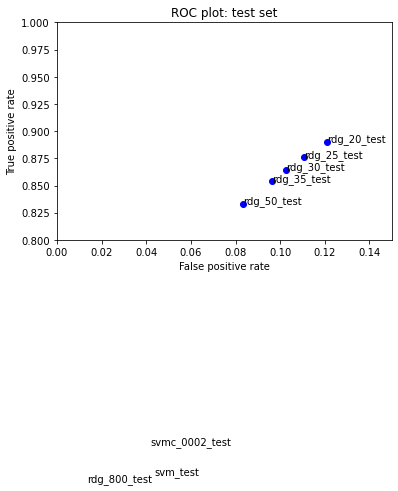

In [34]:
# fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
# fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
# fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]
# fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_800_performance_test, rdg_50000_performance_test, rdg_50_performance_test, svmc_0002_performance_test]
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_800_performance_test, rdg_50000_performance_test, rdg_50_performance_test, rdg_30_performance_test,rdg_20_performance_test, rdg_25_performance_test, rdg_35_performance_test,svmc_0002_performance_test]


for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

fits_small = [svm_performance_test, rdg_50_performance_test, rdg_30_performance_test,rdg_20_performance_test, rdg_25_performance_test, rdg_35_performance_test, rdg_800_performance_test, svmc_0002_performance_test]


for fit in fits_small:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.15, 0.8, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [35]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../../data/toxiccomments_test.csv', my_random_seed=1999, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  exclaim_count  quest_count
0          72              0            0
1          13              0            0
2          16              0            0
3          38              0            0
4           7     

---
In this iteration, I am choosing the **Ridge Regression (alpha = 25, solver = 'sag')** model fit, which is in the `rdg_25` object. 

In [36]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg_25.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())


0.2993457992739808


In [37]:
raw_data.head()

,id,comment_text,word_count,exclaim_count,quest_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,0,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,0,0


In [38]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [39]:
my_submission.shape

(153164, 2)

In [40]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('submission/toxiccomments_submission_iter_3.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation